In [1]:
!pip install --quiet datasets transformers scikit-learn pandas joblib gradio matplotlib


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train shape: (25000, 2)
                                                text  label
0  I rented I AM CURIOUS-YELLOW from my video sto...      0
1  "I Am Curious: Yellow" is a risible and preten...      0
2  If only to avoid making this type of film in t...      0
3  This film was probably inspired by Godard's Ma...      0
4  Oh, brother...after hearing about this ridicul...      0


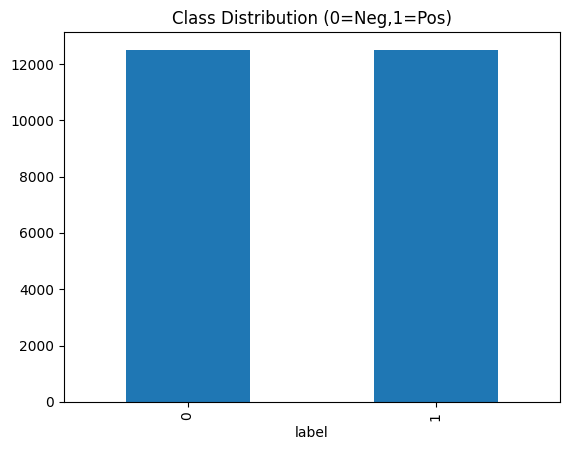

In [2]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt

# Load IMDB dataset
dataset = load_dataset("imdb")
train = pd.DataFrame(dataset['train'])
test = pd.DataFrame(dataset['test'])

print("Train shape:", train.shape)
print(train.head())

# Class balance
train['label'].value_counts().plot(kind="bar", title="Class Distribution (0=Neg,1=Pos)")
plt.show()


In [3]:
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

X_train = train['text'].tolist()
y_train = train['label'].tolist()
X_test = test['text'].tolist()
y_test = test['label'].tolist()

# Vectorizer
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

# Evaluation
y_pred = clf.predict(X_test_tfidf)
print("Baseline Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Save
joblib.dump(clf, "model_real.pkl")
joblib.dump(vectorizer, "vectorizer_real.pkl")


Baseline Accuracy: 0.89256
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     12500
           1       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



['vectorizer_real.pkl']

In [4]:
from transformers import pipeline, set_seed

generator = pipeline("text-generation", model="distilgpt2")
set_seed(42)

synthetic_texts, synthetic_labels = [], []

# Positive reviews
for _ in range(100):
    g = generator("This movie was amazing", max_length=50, do_sample=True)[0]['generated_text']
    synthetic_texts.append(g)
    synthetic_labels.append(1)

# Negative reviews
for _ in range(100):
    g = generator("This movie was terrible", max_length=50, do_sample=True)[0]['generated_text']
    synthetic_texts.append(g)
    synthetic_labels.append(0)

print("Synthetic samples:", len(synthetic_texts))
print(synthetic_texts[:2])


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=50) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformer

Synthetic samples: 200
["This movie was amazing for the movie that it was, and I had never seen it before, but it's all worth it. The movie was fun, and the soundtrack was great. That was my favorite movie ever.\n\nI absolutely adore the film.\nI have watched it for hours, and I can't wait. I'll continue to watch it.\nThe story of the movie was different, in many respects. I liked it and loved it.\nI am still very excited to watch it.\nI will be working on it.\nI am very excited to see it again.\nOne of the biggest things I will be doing is getting to know you and I am very excited to see it again.\nI'm a huge fan of the movie, and love the movie.\nI am so happy to see you on the movie.\nI have a huge love for the movie.", 'This movie was amazing and the music was amazing and the soundtrack really was awesome.']


In [5]:
X_train_aug = X_train + synthetic_texts
y_train_aug = y_train + synthetic_labels

vectorizer_aug = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_aug_tfidf = vectorizer_aug.fit_transform(X_train_aug)
X_test_aug_tfidf = vectorizer_aug.transform(X_test)

clf_aug = LogisticRegression(max_iter=1000)
clf_aug.fit(X_train_aug_tfidf, y_train_aug)

y_pred_aug = clf_aug.predict(X_test_aug_tfidf)
print("Augmented Accuracy:", accuracy_score(y_test, y_pred_aug))
print(classification_report(y_test, y_pred_aug))

# Save
joblib.dump(clf_aug, "model_augmented.pkl")
joblib.dump(vectorizer_aug, "vectorizer_augmented.pkl")


Augmented Accuracy: 0.8934
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     12500
           1       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



['vectorizer_augmented.pkl']

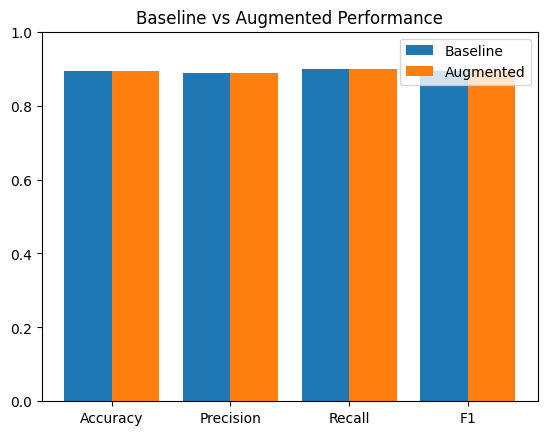

In [6]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

def get_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary")
    return acc, prec, rec, f1

# Metrics
acc_b, prec_b, rec_b, f1_b = get_metrics(y_test, y_pred)
acc_a, prec_a, rec_a, f1_a = get_metrics(y_test, y_pred_aug)

labels = ["Accuracy","Precision","Recall","F1"]
baseline = [acc_b, prec_b, rec_b, f1_b]
augmented = [acc_a, prec_a, rec_a, f1_a]

x = np.arange(len(labels))
plt.bar(x-0.2, baseline, 0.4, label="Baseline")
plt.bar(x+0.2, augmented, 0.4, label="Augmented")
plt.xticks(x, labels)
plt.ylim(0,1)
plt.legend()
plt.title("Baseline vs Augmented Performance")
plt.show()


In [7]:
import gradio as gr

# Load saved models
clf_base = joblib.load("model_real.pkl")
vec_base = joblib.load("vectorizer_real.pkl")
clf_aug = joblib.load("model_augmented.pkl")
vec_aug = joblib.load("vectorizer_augmented.pkl")

def predict_sentiment(text, model_choice):
    if model_choice == "Baseline":
        X = vec_base.transform([text])
        pred = clf_base.predict(X)[0]
    else:
        X = vec_aug.transform([text])
        pred = clf_aug.predict(X)[0]
    return "Positive 😊" if pred==1 else "Negative 😡"

demo = gr.Interface(
    fn=predict_sentiment,
    inputs=[gr.Textbox(lines=3, placeholder="Type a movie review..."),
            gr.Radio(["Baseline","Augmented"], value="Augmented")],
    outputs="text",
    title="Sentiment Analysis with GPT Augmentation"
)

demo.launch(share=True)  # share=True → gives you a public link in Colab


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5eb3e9630279041202.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
